# Inverse Modeling Exploration

/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


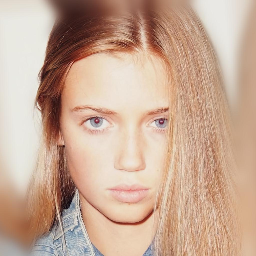

In [25]:
# Imports
from typing import List
import copy

import torch
import torch.nn as nn
from torchvision.io import read_image
from diffusers.pipelines import ScoreSdeVePipeline
from matplotlib import pyplot as plt
from IPython.display import display
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

from mvp_score_modelling.utils import (
    crop,
    resize,
    tensor_to_PIL,
    plt_img
)
from mvp_score_modelling.pipelines.utils import (
    VeTweedie,
    CustomConditionalScoreVePipeline,
)
from mvp_score_modelling.pipelines.super_resolution import (
    PseudoinverseGuidedSuperResolutionPipeline,
    SuperResolutionProjectionPipeline,
    PrYtGuidedSuperResolutionPipeline
)
from mvp_score_modelling.pipelines.colorisation import (
    greyscale,
    ColorisationProjectionPipeline,
    PrYtGuidedColorisationPipeline,
    PseudoinverseGuidedColorisationPipeline,
    ManifoldConstrainedGradientColorisationPipeline
)
from mvp_score_modelling.pipelines.inpainting import (
    MaskGenerator,
    InpaintingProjectionPipeline,
    PseudoinverseGuidedInpaintingPipeline,
    PrYtGuidedInpaintingPipeline,
    ManifoldConstrainedGradientInpaintingPipeline
)
from mvp_score_modelling.pipelines.class_conditional import (
    ClassConditionalClassifierPipeline,
    NoiselessConditionalClassifierPipeline
)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PRETRAINED = "google/ncsnpp-celebahq-256"
EVAL_IMAGE = "data/test_celabhq.png"
INFERENCE_STEPS = 1000

eval_img = crop(resize(read_image(EVAL_IMAGE))) / 256
eval_img = eval_img.to(DEVICE)
display(tensor_to_PIL(eval_img))

In [ ]:
# Metrics
lpips = LearnedPerceptualImagePatchSimilarity().to(DEVICE)
def lpips_eval(img, reference = None):
    if reference == None:
        reference = eval_img.unsqueeze(0)
    return round(lpips(reference, img.to(DEVICE)).item(), 4)

ssim = StructuralSimilarityIndexMeasure().to(DEVICE)
def ssim_eval(img, reference = None):
    if reference == None:
        reference = eval_img.unsqueeze(0)
    return round(ssim(reference, img.to(DEVICE)).item(), 4)

# Utils
def run_pipelines(y, pipelines, unet, scheduler, inference_steps=INFERENCE_STEPS):
    images = []
    for p_class in pipelines:
        pipeline = p_class(unet, scheduler)
        img = pipeline(
            y,
            num_inference_steps=inference_steps,
            output_type=None
        )[0]
        images.append(img)
    return images

def show_pipeline_results(
        reference,
        y,
        images: List[torch.Tensor],
        measurement_function,
        denoiser=None
    ):
    fig, axs = plt.subplots(1,len(images) + 1)
    for ax in axs:
        ax.axis('off')
    plt_img(axs[0], reference)
    axs[0].text(0,300, "y error")
    for i, img in enumerate(images):
        ax = axs[i+1]
        if not denoiser is None:
            img = denoiser(img)
        y_s = measurement_function(img)
        mse = torch.mean((y_s-y)**2).item()     
        plt_img(ax, img.squeeze())
        ax.text(0, 300, f"{mse:.3g}")

## Score-Based Generative Modeling Through Stochastic Differential Equations
Yang Song

diffusion_pytorch_model.safetensors not found
  0%|          | 0/1000 [00:00<?, ?it/s]/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/diffusers/models/resnet.py:488: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),
/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/diffusers/models/resnet.py:388: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),
100%|██████████| 1000/1000 [01:34<00:00, 10.58it/s]


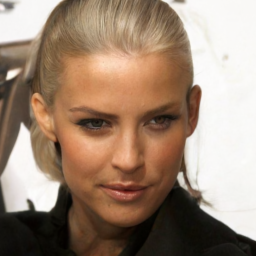

In [2]:
unconditional_pipeline: CustomConditionalScoreVePipeline = CustomConditionalScoreVePipeline.from_pretrained(PRETRAINED).to(device=DEVICE)
tweedie = VeTweedie(unconditional_pipeline.unet)
images = unconditional_pipeline(num_inference_steps=INFERENCE_STEPS, batch_size=1)
display(images[0])

In [ ]:
INITIAL_START = int(INFERENCE_STEPS * 0.5)

sigma = unconditional_pipeline.scheduler.sigmas[INFERENCE_STEPS-INITIAL_START]
z = torch.randn_like(eval_img) * sigma

noised_eval_image = eval_img + z
pipeline = CustomConditionalScoreVePipeline(
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler
).to(DEVICE)
images = pipeline(
    num_inference_steps=INFERENCE_STEPS,
    initial_sample=(noised_eval_image.unsqueeze(0), INITIAL_START),
    output_type = None
)

In [ ]:
fig, axs = plt.subplots(1,3)
for ax in axs:
    ax.axis('off')

axs[0].set_title("Original")
axs[0].text(0,300,"lpips")
axs[0].text(0,340,"ssim")
plt_img(axs[0], eval_img)
axs[1].set_title("One-step denoised")
axs[1].text(0,300,lpips_eval(tweedie(noised_eval_image, sigma)))
axs[1].text(0,340,ssim_eval(tweedie(noised_eval_image, sigma)))
plt_img(axs[1], tweedie(noised_eval_image,sigma).squeeze())
axs[2].set_title("Generated")
axs[2].text(0,300,lpips_eval(images[0].unsqueeze(0)))
axs[2].text(0,340,ssim_eval(images[0].unsqueeze(0)))
plt_img(axs[2], images[0])

# Face Swap

In [ ]:
class FlexibileInpaintingProjectionPipeline(CustomConditionalScoreVePipeline):
    """ Solves the conditional inpainting problem with lambda flexibility hyperparameter
    as specified by song https://arxiv.org/abs/2111.08005
    """
    def initialise_inference(self, y, generator, batch_size: int, n: int):
        """ Run at the start of an inference run

        Args:
            y: Measurement and corresponding data
            generator: Random numbers
            batch_size (int): Number of images to generate
            n (int): Inference steps

        Returns:
            sample: The initial random sample noise
        """
        self.reference_image, self.mask, self.lmbda = y
        self.masked_reference_image = self.reference_image * self.mask
        return super().initialise_inference(y, generator, batch_size, n)

    def constraint_projection(self, y, x_t, sigma_t):
        """ Replaces the unmasked areas of backwards sample x_t with mixture
        of generated y_t and x_t
        """
        y_t = (self.reference_image + torch.randn_like(x_t) * sigma_t) * self.mask
        x_t = x_t * (1. - self.mask) + y_t * self.lmbda + x_t * self.mask * (1-self.lmbda)
        return x_t
    
    @torch.no_grad()
    def __call__(
        self,
        y = None,
        batch_size: int = 1,
        num_inference_steps: int = 2000,
        generator = None,
        output_type= "pil",
        initial_sample = None,
        alpha = 1
    ):
        # Initialise
        tweedie = VeTweedie(self.unet)
        sample, start = self.initialise_inference(y, generator, batch_size, num_inference_steps), 0
        if not initial_sample is None:
            sample, start = initial_sample[0], num_inference_steps - initial_sample[1]

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps[start:])):
            std = self.scheduler.sigmas[i+start]
            sigma_t = std * torch.ones(batch_size, device=self.device)

            # Constraint Projection (prepend for assumption on sigma)
            sample = self.constraint_projection(y, sample, sigma_t)
            x_t = sample

            # correction step
            for _ in range(self.scheduler.config.correct_steps):
                score = self.calculate_score(y, sample, sigma_t)
                sample = self.scheduler.step_correct(score, sample, generator=generator).prev_sample

            # prediction step
            sample = self.constraint_projection(y, sample, sigma_t)
            score = self.calculate_score(y, sample, sigma_t)
            output = self.scheduler.step_pred(score, t, sample, generator=generator)
            sample = output.prev_sample

            # MCG
            with torch.enable_grad():
                x_t.requires_grad = True
                x_hat = tweedie(x_t, sigma_t)
                y_hat = self.mask * x_hat
                dist = (y_hat - self.masked_reference_image).pow(2)
                dist_norm = torch.sqrt(dist.sum([-1,-2,-3]))
                a = alpha / dist_norm
                dist.sum().backward()
                a.reshape((*a.shape, 1, 1, 1))
                sample = sample - a * x_t.grad

        return self.organise_output(output, output_type)

    
face = (crop(resize(read_image("data/celab/1.png"))) / 256).to(DEVICE)
head = (crop(resize(read_image("data/celab/10.png"))) / 256).to(DEVICE)

mask_gen = MaskGenerator(face.unsqueeze(0).shape, device=DEVICE)
face_mask = 1 - mask_gen.generate_box_mask(size=60)
head_mask = mask_gen.generate_box_mask(size=100)

face = face * face_mask
head = head * head_mask

combined_mask = face_mask + head_mask
combined = face + head

pipeline = FlexibileInpaintingProjectionPipeline(unconditional_pipeline.unet, unconditional_pipeline.scheduler)
img_1 = pipeline(
    (combined, combined_mask, 0.3),
    num_inference_steps=1000,
    output_type=None,
    alpha=1
)[0]
img_2 = pipeline(
    (combined, combined_mask, 0.7),
    num_inference_steps=1000,
    output_type=None,
    alpha=1
)[0]
img_3 = pipeline(
    (combined, combined_mask, 1),
    num_inference_steps=1000,
    output_type=None,
    alpha=1
)[0]

fig, axs = plt.subplots(1,6)
for ax in axs:
    ax.axis('off')

face_ = (crop(resize(read_image("data/celab/1.png"))) / 256).to(DEVICE)
head_ = (crop(resize(read_image("data/celab/10.png"))) / 256).to(DEVICE)

fig.set_size_inches(10,3)

plt_img(axs[0], face_)
plt_img(axs[1], head_)
plt_img(axs[2], combined)
plt_img(axs[3], img_1)
plt_img(axs[4], img_2)
plt_img(axs[5], img_3)

axs[0].set_title("Face")
axs[1].set_title("Merging")
axs[2].set_title("λ")
axs[3].set_title(0.3)
axs[4].set_title(0.7)
axs[5].set_title(1)

# Super-resolution

In [ ]:
KERNEL_SIZE = 16
pool = nn.AvgPool2d(kernel_size=KERNEL_SIZE, stride=KERNEL_SIZE)
downsampled_img = pool(eval_img).to(device=DEVICE)

pipelines = [
    SuperResolutionProjectionPipeline,
    PrYtGuidedSuperResolutionPipeline,
    PseudoinverseGuidedSuperResolutionPipeline
]

images = run_pipelines(
    y = (downsampled_img, KERNEL_SIZE),
    pipelines = pipelines,
    unet=unconditional_pipeline.unet,
    scheduler=unconditional_pipeline.scheduler
)

show_pipeline_results(
    SuperResolutionProjectionPipeline.upscale(downsampled_img, KERNEL_SIZE),
    downsampled_img,
    images,
    pool
)

# Colorisation

In [ ]:
grey = greyscale(eval_img)

pipelines = [
    ColorisationProjectionPipeline,
    PrYtGuidedColorisationPipeline,
    PseudoinverseGuidedColorisationPipeline,
    ManifoldConstrainedGradientColorisationPipeline
]
images = run_pipelines(
    grey,
    pipelines,
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler,
    inference_steps=500
)
show_pipeline_results(grey.squeeze(), grey, images, greyscale)

# Imputation

In [ ]:
mask_gen = MaskGenerator(eval_img.unsqueeze(0).shape)
mask = mask_gen.generate_box_mask(size=80).to(device=DEVICE)

pipelines = [
    InpaintingProjectionPipeline,
    PrYtGuidedInpaintingPipeline,
    PseudoinverseGuidedInpaintingPipeline,
    ManifoldConstrainedGradientInpaintingPipeline
]

images = run_pipelines(
    (eval_img.unsqueeze(0), mask),
    pipelines,
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler
)
show_pipeline_results(mask * eval_img, (eval_img * mask).unsqueeze(0), images, lambda x: x * mask)

In [ ]:
mask_gen = MaskGenerator(eval_img.unsqueeze(0).shape)
mask = mask_gen.generate_random_mask().to(device=DEVICE)

pipelines = [
    InpaintingProjectionPipeline,
    PrYtGuidedInpaintingPipeline,
    PseudoinverseGuidedInpaintingPipeline,
    ManifoldConstrainedGradientInpaintingPipeline
]

images = run_pipelines(
    (eval_img.unsqueeze(0), mask),
    pipelines,
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler
)
show_pipeline_results(mask * eval_img, (eval_img * mask).unsqueeze(0), images, lambda x: x * mask)

# Class Conditional

In [97]:
torch.manual_seed(1)
BATCH_SIZE = 6
random_noise =  unconditional_pipeline.scheduler.sigmas[0] * torch.randn(BATCH_SIZE,3,256,256).to(device=DEVICE)
UNCONDITIONAL_CLASSIFIER_CKPT = "../checkpoints/default.pt"

classifier = torch.load(UNCONDITIONAL_CLASSIFIER_CKPT)
pipeline = NoiselessConditionalClassifierPipeline(
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler
)
tweedie_conditional = pipeline(
    (classifier, 0),
    num_inference_steps=INFERENCE_STEPS,
    batch_size=BATCH_SIZE,
    output_type=None,
    initial_sample=(copy.deepcopy(random_noise), INFERENCE_STEPS)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/diffusers/models/resnet.py:488: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),
/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/diffusers/models/resnet.py:388: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kernel, device=hidden_states.device),
/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 1000/1000 [27:09<0

In [98]:
torch.manual_seed(1)
random_noise =  unconditional_pipeline.scheduler.sigmas[0] * torch.randn(BATCH_SIZE,3,256,256).to(device=DEVICE)

NOISE_CONDITIONAL_CLASSIFIER_CKPT = "../checkpoints/noise-conditional.pt"
noise_classifier = torch.load(NOISE_CONDITIONAL_CLASSIFIER_CKPT)
noise_pipeline = ClassConditionalClassifierPipeline(
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler
)
noise_conditional = noise_pipeline(
    (noise_classifier, 1),
    num_inference_steps=INFERENCE_STEPS,
    batch_size=BATCH_SIZE,
    output_type=None,
    initial_sample=(copy.deepcopy(random_noise), INFERENCE_STEPS)
)

100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


In [99]:
torch.manual_seed(1)
random_noise =  unconditional_pipeline.scheduler.sigmas[0] * torch.randn(BATCH_SIZE,3,256,256).to(device=DEVICE)

pipeline = CustomConditionalScoreVePipeline(
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler
)
unconditional = pipeline(
    (None),
    num_inference_steps=INFERENCE_STEPS,
    batch_size=BATCH_SIZE,
    output_type=None,
    initial_sample=(copy.deepcopy(random_noise), INFERENCE_STEPS)
)

100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Text(-250, 128, 'Tweedie Classifier')

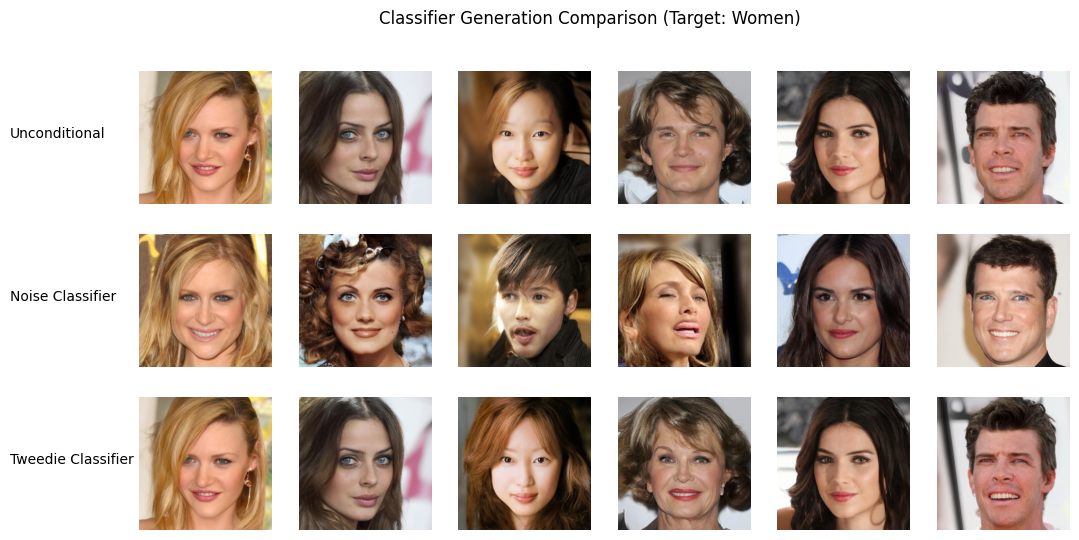

In [101]:
fig, axs = plt.subplots(3,len(unconditional))
fig.set_size_inches(len(unconditional)*2,6)
for row in axs:
    for ax in row:
        ax.axis('off')

data = [unconditional, noise_conditional, tweedie_conditional]
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        plt_img(ax,data[i][j])

fig.suptitle("Classifier Generation Comparison (Target: Women)")
axs[0][0].text(-250,128,"Unconditional")
axs[1][0].text(-250,128,"Noise Classifier")
axs[2][0].text(-250,128,"Tweedie Classifier")


tensor([[-3.1505,  3.0905]], device='cuda:0', grad_fn=<AddmmBackward0>)


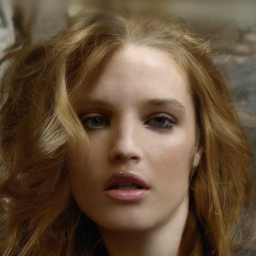

In [94]:
print(noise_classifier(tweedie_conditional[2].unsqueeze(0), torch.tensor([0]).to(DEVICE)))
display(tensor_to_PIL(tweedie_conditional[2]))